In [3116]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
                
        transient = ((self._rho*self._cp*self._grid.vol)*(self._T[1:-1] - self._Told[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [3117]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
            k.......thermal conductivity
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [3118]:
# Grid test 1 for ncv 8
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    
    #Storing Temperature for Grid Test
    Tg1 = T
    xP1 = grid.xP


Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 7.383535135776128; Avg. Resid. = 6.51317112967952
Iteration = 1; Max. Resid. = 1.0391687510491465e-13; Avg. Resid. = 6.38378239159465e-14
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 6.932445494374406; Avg. Resid. = 6.117028448334125
Iteration = 1; Max. Resid. = 8.08242361927114e-14; Avg. Resid. = 4.474198789239381e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 6.508835194436642; Avg. Resid. = 5.744578576396137
Iteration = 1; Max. Resid. = 9.414691248821327e-14; Avg. Resid. = 3.108624468950438e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 6.111434068438825; Avg. Resid. = 5.394685502167192
Iteration = 1; Max. Resid. = 5.551115123125783e-14; Avg. Resid. = 3.269606807521086e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 5.738603453000508; Avg. Resid. = 5.066055717848897
Iteration = 1; Max. Resid. = 7.904787935331115e-14; Avg. Resid. = 4.6851411639181606e-14
Timestep = 5; Time = 

[10.68644679 10.68644679 10.56306153 10.31771561  9.9532418   9.47384827
  8.8850701   8.19370529  7.40773631  6.97198711]


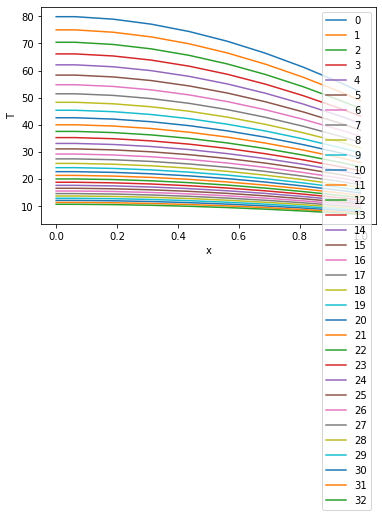

In [3119]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [3120]:
# Grid test 2 for ncv 16
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    
    #Storing Temperature for Grid Test
    Tg2 = T
    xP2 = grid.xP

Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.5002222514558525e-13; Avg. Resid. = 1.2714829189519605e-13
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 3.4727554705034436; Avg. Resid. = 3.061181838663444
Iteration = 1; Max. Resid. = 2.0161650127192843e-13; Avg. Resid. = 8.698597397938101e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 3.2608272954162203; Avg. Resid. = 2.8744759526193064
Iteration = 1; Max. Resid. = 1.5054624213917123e-13; Avg. Resid. = 6.947220576591917e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 3.061856991875402; Avg. Resid. = 2.6991474818645287
Iteration = 1; Max. Resid. = 1.438849039914203e-13; Avg. Resid. = 5.380418333089665e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 2.875051960307701; Avg. Resid. = 2.534509300990891
Iteration = 1; Max. Resid. = 1.7186252421197423e-13; Avg. Resid. = 7.981115768274094e-14
Timestep 

[10.67262853 10.67262853 10.64178358 10.58018281 10.48800425 10.36551433
 10.21306703 10.03110295  9.82014799  9.58081183  9.31378616  9.01984273
  8.69983106  8.354676    7.9853751   7.59299568  7.17867174  6.96113623]


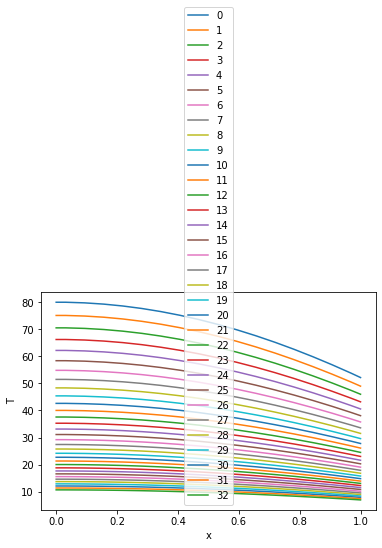

In [3121]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [3122]:
# Grid test 3 for ncv 32
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    #Storing Temperature for Grid Test
    Tg3 = T
    xP3 = grid.xP


Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 1.8500591664023887; Avg. Resid. = 1.630418626624646
Iteration = 1; Max. Resid. = 5.597744490160039e-13; Avg. Resid. = 2.2657570264428273e-13
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 1.7371929826472297; Avg. Resid. = 1.530925427652278
Iteration = 1; Max. Resid. = 6.128431095930864e-13; Avg. Resid. = 1.6191908924767517e-13
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 1.631214099132194; Avg. Resid. = 1.4375115780458998
Iteration = 1; Max. Resid. = 3.588240815588506e-13; Avg. Resid. = 1.462857612821722e-13
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 1.531696252387519; Avg. Resid. = 1.349799425848019
Iteration = 1; Max. Resid. = 3.6126657221302594e-13; Avg. Resid. = 1.279219785654817e-13
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 1.438245553032175; Avg. Resid. = 1.2674398532257527
Iteration = 1; Max. Resid. = 2.7555735471196385e-13; Avg. Resid. = 1.2031001195289548e-13
Timestep = 

[10.66917104 10.66917104 10.66145989 10.64604316 10.622932   10.5921431
 10.55369872 10.50762665 10.45396019 10.39273811 10.32400468 10.24780957
 10.16420784 10.07325993  9.97503156  9.86959373  9.75702264  9.63739965
  9.51081123  9.37734886  9.23710901  9.09019303  8.93670711  8.77676217
  8.61047382  8.43796225  8.25935213  8.07477256  7.88435694  7.6882429
  7.48657217  7.27949052  7.06714761  6.95842226]


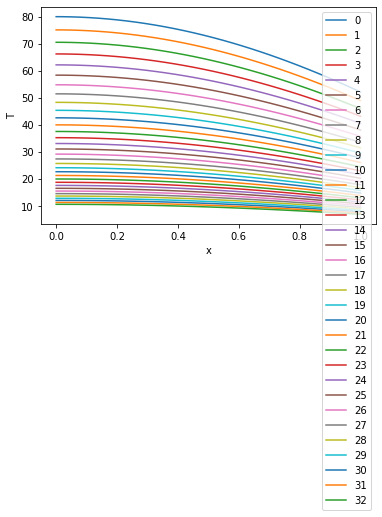

In [3123]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Grid Independency Test (First order Implicit scheme)

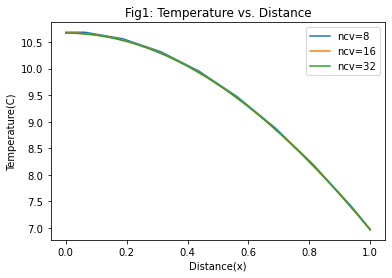

In [3124]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xP1, Tg1, label='ncv=8')
plt.plot(xP2, Tg2, label='ncv=16')
plt.plot(xP3, Tg3, label='ncv=32')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(C)")
plt.legend()
#Display the title
plt.title('Fig1: Temperature vs. Distance')
plt.show()

It is visible from figure 1 that the temperature profile is identical for ncv 8,16 and 32. For the this problem, ncv 16 has been chosen for further comparison.

# First Order Implicit Scheme

In [3125]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T2_1_1 = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 1.9872992140790302e-13; Avg. Resid. = 4.246603069191224e-14
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.8133372355752044; Avg. Resid. = 1.5985435889109354
Iteration = 1; Max. Resid. = 1.0558220964185239e-13; Avg. Resid. = 3.104461132608094e-14


In [3126]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error1 = E_bar

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]


[19.22802015 19.22802015 19.17244911 19.06146765 18.89539652 18.6747157
 18.400063   18.07223222 17.69217086 17.26097735 16.77989793 16.25032299
 15.67378308 15.05194451 14.38660446 13.67968586 12.93323178 12.54131567]


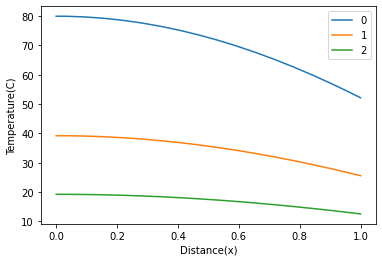

In [3127]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(C)")
plt.legend()
plt.show()

In [3128]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    #Storing the temperature
    dt2 = dt 
    T2_2_1 = T[1]   
    timeStep_2 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 1.7408297026122455e-13; Avg. Resid. = 7.818745650922665e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 2.4334736845104317; Avg. Resid. = 2.1452037427089294
Iteration = 1; Max. Resid. = 2.1760371282653068e-13; Avg. Resid. = 7.784051181403129e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 1.6012486560827028; Avg. Resid. = 1.4116014440072462
Iteration = 1; Max. Resid. = 7.982503547054876e-14; Avg. Resid. = 3.3209546224099995e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 1.0536561886811455; Avg. Resid. = 0.9288689425349261
Iteration = 1; Max. Resid. = 6.894484982922222e-14; Avg. Resid. = 2.362346429585216e-14


In [3129]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error2 = E_bar

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]


In [3130]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
     #Storing the temperature of T at x=0 at t=3.2632 for comparison
    dt3 = dt
    T2_3_1 = T[1]
    timeStep_3 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.0383694732117874e-13; Avg. Resid. = 6.418476861114186e-14
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 2.935428408067878; Avg. Resid. = 2.5876570849006555
Iteration = 1; Max. Resid. = 1.247890679678676e-13; Avg. Resid. = 6.246392292297287e-14
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 2.329913201946624; Avg. Resid. = 2.0539498015669437
Iteration = 1; Max. Resid. = 1.496580637194711e-13; Avg. Resid. = 7.330247520087596e-14
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 1.8493408869538825; Avg. Resid. = 1.6303145927163314
Iteration = 1; Max. Resid. = 1.1513012765362873e-13; Avg. Resid. = 4.989758606299688e-14
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 1.4679020728859768; Avg. Resid. = 1.294054831771838
Iteration = 1; Max. Resid. = 1.02140518

In [3131]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error3 = E_bar

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]


In [3132]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    #Storing the temperature of T at x=0 at t=3.2632 for comparison
    dt4 = dt
    T2_4_1 = T[1]
    timeStep_4 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.948752353404416e-13; Avg. Resid. = 1.3636314299958485e-13
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 3.2730225202069505; Avg. Resid. = 2.885191896078524
Iteration = 1; Max. Resid. = 1.354472090042691e-13; Avg. Resid. = 6.356026815979021e-14
Timestep = 2; Time = 0.9803180000000001
Iteration = 0; Max. Resid. = 2.896574431552267; Avg. Resid. = 2.553451956773003
Iteration = 1; Max. Resid. = 1.3944401189291966e-13; Avg. Resid. = 4.2799097599299785e-14
Timestep = 3; Time = 1.1559240000000002
Iteration = 0; Max. Resid. = 2.5634692545000917; Avg. Resid. = 2.2598466547783005
Iteration = 1; Max. Resid. = 1.949551631241775e-13; Avg. Resid. = 6.356026815979021e-14
Timestep = 4; Time = 1.33153
Iteration = 0; Max. Resid. = 2.2686927482931196; Avg. Resid. = 1.9999987187882553
Iteration = 1; Max. Resid. = 1.574296248918472e-13; Avg. Re

In [3133]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error4 = E_bar

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]


In [3134]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    #Storing the temperature of T at x=0 at t=3.2632 for comparison
    dt5 = dt
    dt1_5 = dt
    T2_5_1 = T[1]
    timeStep_5 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.5002222514558525e-13; Avg. Resid. = 1.2714829189519605e-13
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 3.4727554705034436; Avg. Resid. = 3.061181838663444
Iteration = 1; Max. Resid. = 2.0161650127192843e-13; Avg. Resid. = 8.698597397938101e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 3.2608272954162203; Avg. Resid. = 2.8744759526193064
Iteration = 1; Max. Resid. = 1.5054624213917123e-13; Avg. Resid. = 6.947220576591917e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 3.061856991875402; Avg. Resid. = 2.6991474818645287
Iteration = 1; Max. Resid. = 1.438849039914203e-13; Avg. Resid. = 5.380418333089665e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 2.875051960307701; Avg. Resid. = 2.534509300990891
Iteration = 1; Max. Resid. = 1.7186252421197423e-13; Avg. Resid. = 7.981115768274094e-14
Timestep 

In [3135]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error5 = E_bar

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]


The solpe is 0.9447651967064106


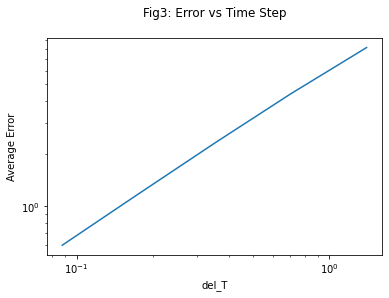

In [3136]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

#slope, intercept, r_value, p_value, stderr = linregress(del_T, Avg_Error)

# Calculating the slope p for first order transient model
Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

Error_log = [Error_1, Error_2, Error_3, Error_4, Error_5]
dt_log = [dt_1, dt_2, dt_3, dt_4, dt_5]
linregress(dt_log, Error_log)

slope, intercept, r_value, p_value, stderr = linregress(dt_log, Error_log)
plt.loglog(del_T, Avg_Error)

print('The solpe for first order implicit scheme is', slope)
plt.title('Fig3: Error vs Time Step\n')
plt.xlabel("del_T")
plt.ylabel("Average Error")
plt.show()

## Error calculation:

Figure 3 shows the error vs time step curve in loglog scale. The solpe of the curve is 0.9~1 which is expected as the data has been obtained using a first order implicit scheme. 

## Temperature vs Time Step

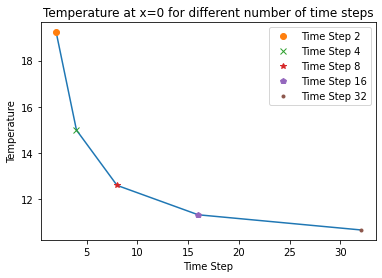

In [3137]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

Time_Step1 = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature1 = [T2_1_1, T2_2_1, T2_3_1, T2_4_1, T2_5_1]
plt.plot(Time_Step1,Temperature1)

plt.plot(timeStep_1, T2_1_1 , 'o', label='Time Step 2')
plt.plot(timeStep_2, T2_2_1 , 'x', label='Time Step 4')
plt.plot(timeStep_3, T2_3_1 , '*', label='Time Step 8')
plt.plot(timeStep_4, T2_4_1 ,'p',  label='Time Step 16')
plt.plot(timeStep_5, T2_5_1 ,'.',  label='Time Step 32')

plt.title('Temperature at x=0 for different number of time steps')
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


The above figure shows the temperature values at x=0 for the final time 3.2632 for different time steps. With the increasing number of time steps, the numerical values reach the exact value asymptotically. For a first-order fully implicit scheme, it evaluates integrands on the right side of the equation above at the final time level,  𝑡1=𝑡+Δ𝑡 as a result, the numerical values get closer to the exact solution with increasing time steps.

## Second order implicit scheme

In [3138]:
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        transient = ((self._rho*self._cp*self._grid.vol)*(1.5*self._T[1:-1] - 2*self._Told[1:-1] + 0.5*self._Told2[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (1.5*(self._rho*self._cp*self._grid.vol))/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [3139]:
# Grid test 1 for ncv 8
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T2_1 = T[1]
    timeStep_1 = nTime
    dt1 = dt
    T_solns.append(np.copy(T))
    
    #Storing Temperature for Grid Test
    Tg1 = T
    xP1 = grid.xP

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 7.383535135776128; Avg. Resid. = 6.51317112967952
Iteration = 1; Max. Resid. = 2.1938006966593093e-13; Avg. Resid. = 9.198197759019422e-14
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 5.815017921833878; Avg. Resid. = 5.133192592512099
Iteration = 1; Max. Resid. = 6.106226635438361e-14; Avg. Resid. = 2.6922908347160046e-14


In [3140]:
# Grid test 2 for ncv 16
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T2_1 = T[1]
    timeStep_1 = nTime
    dt1 = dt
    T_solns.append(np.copy(T))
    
    #Storing Temperature for Grid Test
    Tg2 = T
    xP2 = grid.xP

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.3381296898605797e-13; Avg. Resid. = 1.1318723736053471e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 2.912605702191563; Avg. Resid. = 2.567589127269107
Iteration = 1; Max. Resid. = 1.3999912340523224e-13; Avg. Resid. = 5.694056337546272e-14


In [3141]:
# Grid tets for ncv 32
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T1_1 = T[1]
    timeStep_1 = nTime
    dt1 = dt
    T_solns.append(np.copy(T))
    
    #Storing Temperature for Grid Test
    Tg3 = T
    xP3 = grid.xP

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 1.8500591664023884; Avg. Resid. = 1.630418626624646
Iteration = 1; Max. Resid. = 3.8957725934096743e-13; Avg. Resid. = 1.3593640102449456e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.4569400996633828; Avg. Resid. = 1.2839187625100237
Iteration = 1; Max. Resid. = 2.6278978992877455e-13; Avg. Resid. = 9.841780168606817e-14


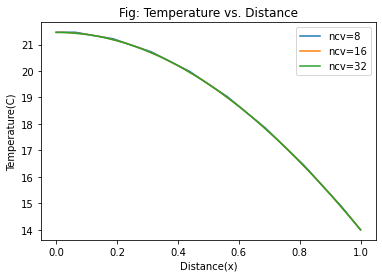

In [3142]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xP1, Tg1, label='ncv=8')
plt.plot(xP2, Tg2, label='ncv=16')
plt.plot(xP3, Tg3, label='ncv=32')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(C)")
plt.legend()
#Display the title
plt.title('Fig: Temperature vs. Distance')
plt.show()

## Grid Test (Second order implicit scheme)


It is visible from the above figure that the temperature profile is identical for ncv 8,16 and 32. For the this problem, ncv 16 has been chosen for further comparison.

In [3143]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T2_1 = T[1]
    timeStep_1 = nTime
    dt1 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.3381296898605797e-13; Avg. Resid. = 1.1318723736053471e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 2.912605702191563; Avg. Resid. = 2.567589127269107
Iteration = 1; Max. Resid. = 1.3999912340523224e-13; Avg. Resid. = 5.694056337546272e-14


[21.45843837 21.45843837 21.39642197 21.27256841 21.08723559 20.84095913
 20.53445072 20.16859615 19.74445269 19.26324606 18.72636685 18.13536655
 17.49195303 16.7979856  16.05546964 15.26655077 14.43350871 13.99612966]


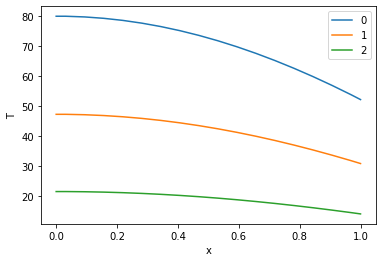

In [3144]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [3145]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error1 = E_bar
print(E_bar)

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]
10.105037502765386


In [3146]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #Storing the temperature at x = 0 
    T2_2 = T[1]
    timeStep_2 = nTime
    dt2 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.162714451969805e-13; Avg. Resid. = 9.804657086220914e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.6621045437680566; Avg. Resid. = 3.228264400948464
Iteration = 1; Max. Resid. = 2.384759056894836e-13; Avg. Resid. = 1.230682222796986e-13
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 2.7107607821517945; Avg. Resid. = 2.3897226011987875
Iteration = 1; Max. Resid. = 1.3233858453531866e-13; Avg. Resid. = 5.74054692670245e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 1.7777483766966329; Avg. Resid. = 1.5672154530481448
Iteration = 1; Max. Resid. = 4.29101199017623e-14; Avg. Resid. = 2.1840168562548e-14


In [3147]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error2 = E_bar
print(E_bar)

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]
3.56517209840921


In [3148]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_3 = T[1]
    timeStep_3 = nTime
    dt3 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.2248869413488137e-13; Avg. Resid. = 1.1018963519404679e-13
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.202901776043291; Avg. Resid. = 3.704923098570225
Iteration = 1; Max. Resid. = 1.9473311851925246e-13; Avg. Resid. = 9.441059045656175e-14
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 3.7255492774473664; Avg. Resid. = 3.2842902146330126
Iteration = 1; Max. Resid. = 2.369215934550084e-13; Avg. Resid. = 6.657174811408595e-14
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.039839484349134; Avg. Resid. = 2.679837332101142
Iteration = 1; Max. Resid. = 9.592326932761353e-14; Avg. Resid. = 4.234113060164191e-14
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 2.3961882005368285; Avg. Resid. = 2.1124112633502277
Iteration = 1; Max. Resid. = 1.40887301

In [3149]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error3 = E_bar
print(E_bar)

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]
1.2973570569672408


[11.46753729 11.46753729 11.43439496 11.36820609 11.26916198 11.13754886
 10.97374712 10.77823016 10.55156304 10.29440085 10.00748682  9.69165016
  9.34780366  8.97694109  8.58013427  8.15853     7.71334678  7.479609  ]


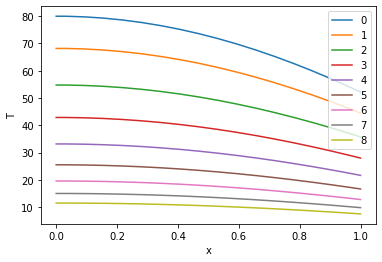

In [3150]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [3151]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.17560625
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_4 = T[1]
    timeStep_4 = nTime
    dt4 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.69562150378988e-13; Avg. Resid. = 1.0860756738395594e-13
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 4.538018682611746; Avg. Resid. = 4.000236271395281
Iteration = 1; Max. Resid. = 1.9628743075372768e-13; Avg. Resid. = 9.509060205914466e-14
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 4.433689431371059; Avg. Resid. = 3.908463849283048
Iteration = 1; Max. Resid. = 1.8096635301390052e-13; Avg. Resid. = 6.081246617384295e-14
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.048219123639598; Avg. Resid. = 3.56875861227444
Iteration = 1; Max. Resid. = 1.603162047558726e-13; Avg. Resid. = 8.243405957841787e-14
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 3.6072823711131314; Avg. Resid. = 3.1800746176417976
Iteration = 1; Max. Resid. = 1.7896795156957523e-13

In [3152]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error4 = E_bar
print(E_bar)

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]
0.5973926902699476


[10.67353824 10.67353824 10.64269065 10.58108463 10.48889822 10.36639785
 10.21393756 10.03195798  9.82098504  9.58162847  9.31458005  9.02061156
  8.7005726   8.35538813  7.98605576  7.59364288  7.17928363  6.96172958]


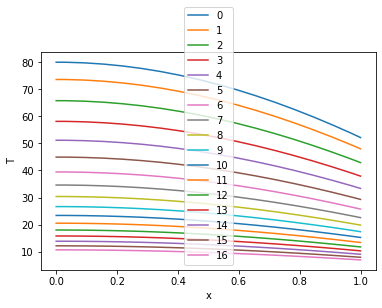

In [3153]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [3154]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    T2_5 = T[1]
    timeStep_5 = nTime
    dt5 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.541303125
Iteration = 0; Max. Resid. = 3.6984470809745744; Avg. Resid. = 3.2599690081853083
Iteration = 1; Max. Resid. = 2.233768725545815e-13; Avg. Resid. = 8.151812558310212e-14
Timestep = 1; Time = 0.62910625
Iteration = 0; Max. Resid. = 4.726483359269564; Avg. Resid. = 4.166270105409754
Iteration = 1; Max. Resid. = 1.1191048088221578e-13; Avg. Resid. = 4.929390229335695e-14
Timestep = 2; Time = 0.716909375
Iteration = 0; Max. Resid. = 4.8586167936523825; Avg. Resid. = 4.282903271524373
Iteration = 1; Max. Resid. = 2.091660178393795e-13; Avg. Resid. = 7.840950111415168e-14
Timestep = 3; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 4.699053681029149; Avg. Resid. = 4.142387054516119
Iteration = 1; Max. Resid. = 1.1723955140041653e-13; Avg. Resid. = 4.1744385725905886e-14
Timestep = 4; Time = 0.8925156249999999
Iteration = 0; Max. Resid. = 4.45296839991182; Avg. Resid. = 3.9255415586117888
Iteration = 1; Max. Resid. = 1.3455903058456897e-13; Avg. Resid.

In [3155]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
    Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error5 = E_bar
print(E_bar)

[9.9996306  9.9960171  9.96712479 9.90942369 9.82308056 9.70834498
 9.56554857 9.39510407 9.19750414 8.9733199  8.72319934 8.4478654
 8.1481139  7.82481125 7.47889189 7.11135569 6.72326495 6.52185993]
0.29582884333167536


[10.3314617  10.3314617  10.30160275 10.24197114 10.15273921 10.03416486
  9.88659078  9.71044346  9.506232    9.27454658  9.01605679  8.73150971
  8.4217277   8.08760605  7.73011042  7.350274    6.94919456  6.7386129 ]


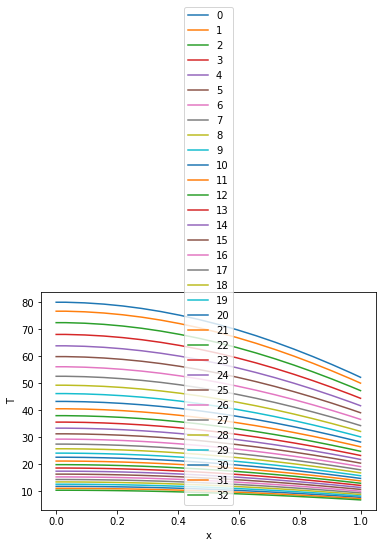

In [3156]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Error vs dt plot

[1.5030310505846927, 1.4583961293541579, 1.1188241009686937, 1.0139168627041726]
The  slope is 1.2765556517546286


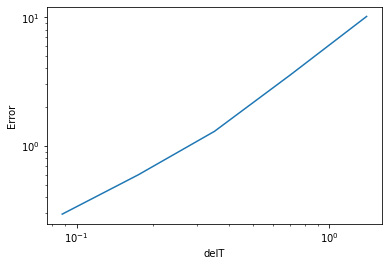

In [3157]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

# Calculating the slope p for second order transient model

Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

Error_log = [Error_1, Error_2, Error_3, Error_4, Error_5]
dt_log = [dt_1, dt_2, dt_3, dt_4, dt_5]
slope, intercept, r, p, se =linregress(dt_log, Error_log)

plt.loglog(del_T, Avg_Error)
slope_Manual = [(Error_1-Error_2)/(dt_1-dt_2), (Error_2-Error_3)/(dt_2-dt_3), (Error_3-Error_4)/(dt_3-dt_4), (Error_4-Error_5)/(dt_4-dt_5) ]
print(slope_Manual)
print('The  slope for Second order implicit scheme is', slope)


plt.xlabel("delT")
plt.ylabel("Error")
plt.show()

The slope for the second-order implicit scheme is 1.27. The expected slope for the second-order scheme is 2. The variation in the slope value could be a result of other introduced errors within the procedure. It is clear that the solution error indicates second order accuracy. The slight differences between the error values obtained hereare due to the number of decimal values carried during computations.

## Temperature vs Time Step plot

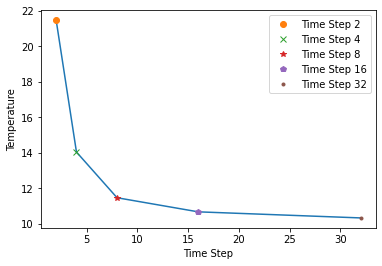

In [3158]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
Time_Step = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature = [T2_1, T2_2, T2_3, T2_4, T2_5]
plt.plot(Time_Step,Temperature)

plt.plot(timeStep_1, T2_1 , 'o', label='Time Step 2')
plt.plot(timeStep_2, T2_2 , 'x', label='Time Step 4')
plt.plot(timeStep_3, T2_3 , '*', label='Time Step 8')
plt.plot(timeStep_4, T2_4 ,'p',  label='Time Step 16')
plt.plot(timeStep_5, T2_5 , '.',  label='Time Step 32')

plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

The above figure shows the temperature at x=0 for the final time 3.2632 . 

# Comparison between First and Second order implicit Scheme

Temp for First order scheme [19.228020146847673, 14.993667205713711, 12.600523653606004, 11.327826040940899, 10.672628534668071]
Temp for Second order scheme [21.458438366717985, 14.040013285896446, 11.467537286500924, 10.673538239060852, 10.331461697548567]


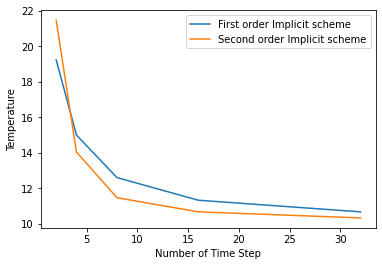

In [3159]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress


Time_Step1 = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature1 = [T2_1_1, T2_2_1, T2_3_1, T2_4_1, T2_5_1]

plt.plot(Time_Step1,Temperature1, label='First order Implicit scheme')
print('Temp for First order scheme', Temperature1)

Time_Step = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature = [T2_1, T2_2, T2_3, T2_4, T2_5]

plt.plot(Time_Step,Temperature, label='Second order Implicit scheme')
print('Temp for Second order scheme', Temperature)



plt.xlabel("Number of Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


The above figure shows the temperature at x=0 at time 3.2632 for different number of time steps(2,4,8,16 and 32) for both first and second order implicit scheme. It is visible that the second order scheme approaches the exact solution more quickly than the first order scheme. For the second order implicit scheme the interpolation model has to be modified to account for the old t temperature till two consecutive steps which eventually predicts the data closer to the exact solution. On the other hand, the fully implicit first order implicit scheme only accounts for t old temperature.

## Crank Nicolson Scheme

In [3160]:
class DiffusionModel_CrankNicolson1:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc, w, phi_old):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._w = w
        self._phi_old = phi_old
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = -self._w*self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = -self._w*self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        flux_w_CN = -( 1 - self._w)*self._gamma*self._grid.Aw*(self._phi_old[1:-1]-self._phi_old[0:-2])/self._grid.dx_WP
        flux_e_CN = -(1- self._w)*self._gamma*self._grid.Ae*(self._phi_old[2:]-self._phi_old[1:-1])/self._grid.dx_PE
       
        # Calculate the linearization coefficients
        coeffW = - self._w*self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._w*self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = ( - coeffW - coeffE)
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = (flux_e - flux_w) + (flux_e_CN - flux_w_CN)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [3161]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
       # coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    T2_1_CN = T[1]
    timeStep_1 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.0436096431476471e-13; Avg. Resid. = 5.74651437545981e-14
[25.28097817 25.28097817 25.09419642 24.72201749 24.16720029 23.43385778
 22.52742669 21.45462743 20.22341468 18.84291876 17.32337849 16.49845571]
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.8678174761308948; Avg. Resid. = 1.6498455705203043
Iteration = 1; Max. Resid. = 4.8627768478581856e-14; Avg. Resid. = 2.0528023725319145e-14
[8.00009986 8.00009986 7.94086419 7.82282409 7.64683866 7.41418813
 7.12656385 6.78605495 6.39513195 5.95662722 5.47371249 5.21305952]


[8.00009986 8.00009986 7.94086419 7.82282409 7.64683866 7.41418813
 7.12656385 6.78605495 6.39513195 5.95662722 5.47371249 5.21305952]


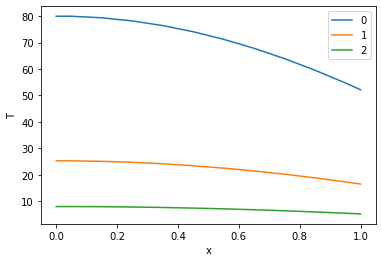

In [3162]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [3163]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt1 = dt
Error1 = E_bar
print(E_bar)

[9.9996306  9.99038091 9.91648609 9.76924301 9.54974078 9.25960296
 8.90097558 8.47651128 7.98934963 7.44309398 6.84178477 6.52185993]
1.7574263590345371


In [3164]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt2 = dt
    T2_2_CN = T[1]
    timeStep_2 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 6.261657858885883e-14; Avg. Resid. = 2.375877272697835e-14
[46.97014526 46.97014526 46.62293725 45.93109542 44.89974924 43.53654588
 41.85159423 39.85739078 37.56872823 35.00258721 32.17801221 30.64572592]
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.4720800253025876; Avg. Resid. = 3.064572591613346
Iteration = 1; Max. Resid. = 3.8191672047105385e-14; Avg. Resid. = 1.5298873279334658e-14
[27.60655405 27.60655405 27.40242658 26.99567135 26.38927612 25.58769322
 24.5968047  23.42387596 22.0774983  20.56752056 18.90497016 18.00473349]
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 2.0412747682320993; Avg. Resid. = 1.800473348804898
Iteration = 1; Max. Resid. = 1.3322676295501878e-14; Avg. Resid. = 6.195044477408373e-15
[16.22346718 16.22346718 16.10348641 15.86442102 15.50805789 15.03706377
 14.4

In [3165]:
# Error Calculation
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(E_bar)
#dt2 = dt
Error2 = E_bar

0.4015523390363683


[9.5349919  9.5349919  9.46453312 9.32412942 9.11480311 8.83807399
 8.49594257 8.09086716 7.62573416 7.10382082 6.52874932 6.2178565 ]


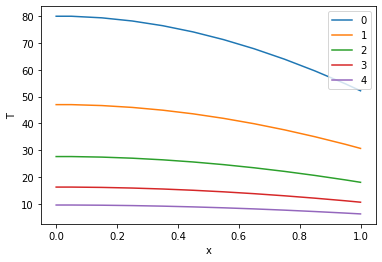

In [3166]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [3167]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt3 = dt
    T2_3_CN = T[1]
    timeStep_3 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 5.10702591327572e-14; Avg. Resid. = 2.2115642650533117e-14
[61.55403498 61.55403498 61.09891143 60.1920402  58.84014859 57.05326671
 54.84465501 52.23070868 49.23083977 45.86733803 42.16521174 40.15734452]
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.551235482879931; Avg. Resid. = 4.015734451550255
Iteration = 1; Max. Resid. = 7.904787935331115e-14; Avg. Resid. = 3.7347902548390263e-14
[47.40725823 47.40725823 47.05678535 46.35842312 45.31731789 43.94113749
 42.24000909 40.22643643 37.91519607 35.32321265 32.46941243 30.92324993]
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 3.504728783034209; Avg. Resid. = 3.0923249929013226
Iteration = 1; Max. Resid. = 4.574118861455645e-14; Avg. Resid. = 1.98507876802978e-14
[36.51129845 36.51129845 36.24129456 35.70328562 34.90125666 33.84115423
 32.53085

In [3168]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt3 = dt
Error3 = E_bar
print(E_bar)

[9.9996306  9.99038091 9.91648609 9.76924301 9.54974078 9.25960296
 8.90097558 8.47651128 7.98934963 7.44309398 6.84178477 6.52185993]
0.08537681461225385


[9.89311266 9.89311266 9.81995883 9.67419747 9.45691719 9.16973963
 8.81480233 8.39472777 7.91256797 7.37170492 6.77567207 6.45302102]


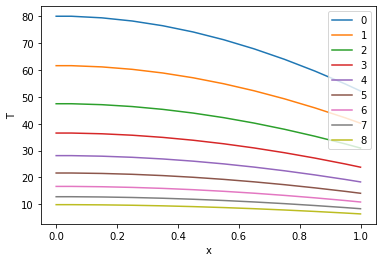

In [3169]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [3170]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.17560625
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    dt4 = dt
    T2_4_CN = T[1]
    timeStep_4 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 6.838973831690964e-14; Avg. Resid. = 3.650413304967515e-14
[70.18021227 70.18021227 69.66121491 68.62707011 67.08545046 65.04779719
 62.52923989 59.5484912  56.12771799 52.29239094 48.07111543 45.78201469]
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.189973563556406; Avg. Resid. = 4.578201469496714
Iteration = 1; Max. Resid. = 4.4853010194856324e-14; Avg. Resid. = 2.2160051571518124e-14
[61.62296313 61.62296313 61.16736544 60.25954079 58.90620335 57.11735557
 54.9062046  52.28904866 49.2851309  45.91645677 42.20756855 40.19768434]
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 4.555976976176551; Avg. Resid. = 4.019768433581429
Iteration = 1; Max. Resid. = 4.973799150320701e-14; Avg. Resid. = 2.3891999489933367e-14
[54.10981594 54.10981594 53.70973257 52.91251767 51.72405456 50.15311851
 48.21132059 45

In [3171]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2632))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  Tex[1:-1] - T[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)
dt4 = dt
print(dt4)
Error4 = E_bar
print(E_bar)

[9.9996306  9.99038091 9.91648609 9.76924301 9.54974078 9.25960296
 8.90097558 8.47651128 7.98934963 7.44309398 6.84178477 6.52185993]
0.17560625
0.007624891321524885


[9.98126003 9.98126003 9.90746127 9.76040887 9.54118836 9.25141747
 8.89323691 8.46930402 7.98278544 7.43729768 6.83656004 6.51100956]


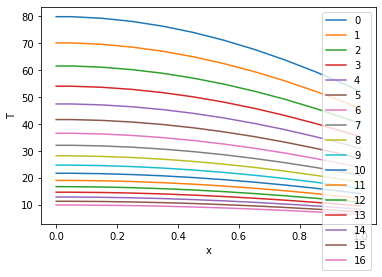

In [3172]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [3173]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878031
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1

T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)

T = T2*np.ones(grid.ncv+2)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson1(grid, T, k, west_bc, east_bc, w , Told)

#Flux = FirstOrder_CrankNicolsonModel(grid, T, k, west_bc, east_bc, w, Told)

# Loop through all timesteps
    

for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = Flux.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    T2_5_CN = T[1]
    timeStep_5 = nTime
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.5413031
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.021405182655144e-13; Avg. Resid. = 3.5438318946034996e-14
[74.90059218 74.90059218 74.34662063 73.24278368 71.59726525 69.42227083
 66.73394507 63.55226533 59.90091511 55.80714296 51.30161587 48.85868179]
Timestep = 1; Time = 0.6291062000000001
Iteration = 0; Max. Resid. = 5.539715484131874; Avg. Resid. = 4.885868178520691
Iteration = 1; Max. Resid. = 1.1723955140041653e-13; Avg. Resid. = 5.098144129078719e-14
[70.18991975 70.18991975 69.67088307 68.63666111 67.09492703 65.05711558
 62.53832997 59.5572111  56.13575972 52.29909416 48.0751118  45.78582076]
Timestep = 2; Time = 0.7169093000000001
Iteration = 0; Max. Resid. = 5.190366774603489; Avg. Resid. = 4.578582076370789
Iteration = 1; Max. Resid. = 4.618527782440651e-14; Avg. Resid. = 2.8599345114344035e-14
[65.77614411 65.77614411 65.28980042 64.32070854 62.87603078 60.96644012
 58.60603978 55.

In [3174]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(E_bar)
print(Tex)
dt5 = dt
Error5 = E_bar

0.013695758997516716
[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


[10.00320824 10.00320824  9.92924606  9.78186855  9.56216536  9.27176096
  8.91280283  8.48794495  8.00032615  7.45355991  6.85167622  6.52540592]


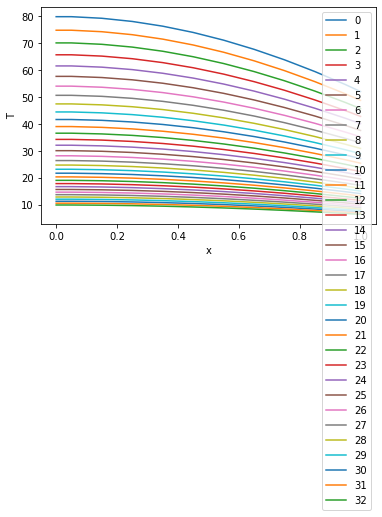

In [3175]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()

The slope is 1.972590775510427


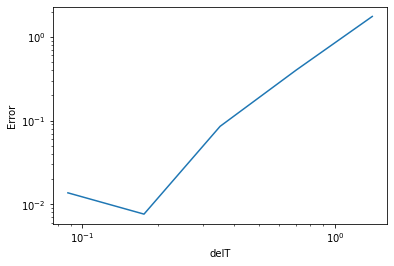

In [3176]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

# Calculating the slope p for second order transient model
Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

#Calculating the slope using linregress
Error_log = [Error_1, Error_2, Error_3, Error_4, Error_5]
dt_log = [dt_1, dt_2, dt_3, dt_4, dt_5]
slope, intercept, r, p, se =linregress(dt_log, Error_log)

plt.loglog(del_T, Avg_Error)

print('The slope for Crank Nicolson scheme is', slope)

plt.xlabel("delT")
plt.ylabel("Error")
plt.show()

# Error Calculation:

The slope for the crank nicolson scheme is 1.97~2 which implies that the crank nicolson scheme is second order. 

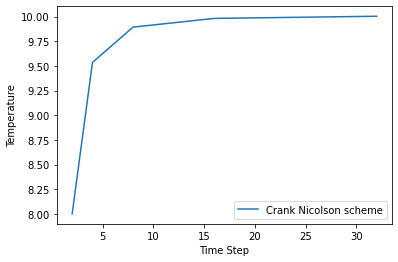

In [3177]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress

Time_Step = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature_CN = [T2_1_CN, T2_2_CN, T2_3_CN, T2_4_CN, T2_5_CN]

plt.plot(Time_Step,Temperature_CN, label='Crank Nicolson scheme')
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Comparison of all the schemes

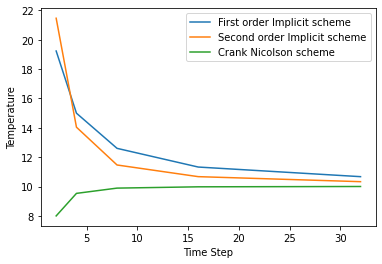

In [3178]:
%matplotlib inline
import matplotlib.pyplot as plt
import math


Time_Step1 = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature1 = [T2_1_1, T2_2_1, T2_3_1, T2_4_1, T2_5_1]

plt.plot(Time_Step1,Temperature1, label='First order Implicit scheme')

Time_Step = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature = [T2_1, T2_2, T2_3, T2_4, T2_5]

plt.plot(Time_Step,Temperature, label='Second order Implicit scheme')

Time_Step = [timeStep_1, timeStep_2, timeStep_3, timeStep_4, timeStep_5]
Temperature_CN = [T2_1_CN, T2_2_CN, T2_3_CN, T2_4_CN, T2_5_CN]

plt.plot(Time_Step,Temperature_CN, label='Crank Nicolson scheme')

plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

## Explanation: 

For first order schemes, the discretization is not affected by whether the time step is variable or constant. The situation is different for second order transient schemes since they use a stencil involving two time step values. For the case of the two step implementation of the Crank-Nicolson transient scheme nothing changes except that for each of the two steps a different time step is used.